AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [28]:
# 📦 1. Importar librerías
import pandas as pd
import numpy as np

In [29]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.preprocessing import StandardScaler

In [30]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [31]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [32]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [33]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [34]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [35]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [36]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [40]:
# # Crear características de lag y rolling
# for lag in [1, 3, 6, 12, 18]:
#     df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'].shift(lag)

# df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).mean()
# df_monthly_product['tn_rolling_std_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).std()

# df_monthly_product['tn_rolling_mean_6'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=6).mean()
# df_monthly_product['tn_rolling_std_6'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=6).std()

# # Diferencia absoluta de tn respecto al mes anterior y mismo mes del año anterior
# df_monthly_product['tn_diff_1']   = df_monthly_product['tn'] - df_monthly_product['tn_lag_1']
# df_monthly_product['tn_diff_12']  = df_monthly_product['tn'] - df_monthly_product['tn_lag_12']

# df_monthly_product['tn_pctchg_1']  = df_monthly_product['tn'].pct_change(periods=1)
# df_monthly_product['tn_pctchg_12'] = df_monthly_product['tn'].pct_change(periods=12)

# # Medias/desviaciones de ventana 9 y 18 meses
# df_monthly_product['tn_roll_mean_9'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=9).mean()
# )
# df_monthly_product['tn_roll_std_9'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=9).std()
# )
# df_monthly_product['tn_roll_mean_18'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=18).mean()
# )
# df_monthly_product['tn_roll_std_18'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=18).std()
# )

# df_monthly_product['tn_expanding_mean'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .expanding(min_periods=1).mean()
#       .reset_index(level=0, drop=True)
# )
# df_monthly_product['tn_expanding_std'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .expanding(min_periods=1).std()
#       .reset_index(level=0, drop=True)
# )

# df_monthly_product['tn_ewm_0.3'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .apply(lambda x: x.shift(1).ewm(alpha=0.3).mean())
# )

# df_monthly_product['month_sin'] = np.sin(2 * np.pi * df_monthly_product['timestamp'].dt.month/12)
# df_monthly_product['month_cos'] = np.cos(2 * np.pi * df_monthly_product['timestamp'].dt.month/12)

# df_monthly_product['tn_yoy_diff']  = df_monthly_product['tn'] - df_monthly_product['tn_lag_12']
# df_monthly_product['tn_yoy_rate']  = df_monthly_product['tn_yoy_diff'] / (df_monthly_product['tn_lag_12'] + 1e-6)

# # p.ej. promedio de tn por categoría de producto (“cat1”)
# df_monthly_product['cat1_tn_mean'] = (
#     df_monthly_product
#       .groupby(['timestamp','cat1'])['tn']
#       .transform('mean')
# )

# # Ejemplo: encoding de brand × lag
# df_monthly_product['brand_lag1'] = (
#     df_monthly_product['brand'].astype('category').cat.codes *
#     df_monthly_product['tn_lag_1']
# )

# Asume que ya tienes df_monthly_product, con índice estándar (RangeIndex)

# 1) Lags de tn
for lag in [1, 3, 6, 12, 18]:
    df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x, l=lag: x.shift(l))

# 2) Rolling mean/std
df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(3).mean())
df_monthly_product['tn_rolling_std_3']  = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(3).std())

df_monthly_product['tn_rolling_mean_6'] = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(6).mean())
df_monthly_product['tn_rolling_std_6']  = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(6).std())

# 3) Diferencias y pct change (por producto)
df_monthly_product['tn_diff_1']   = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x - x.shift(1))
df_monthly_product['tn_diff_12']  = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x - x.shift(12))

df_monthly_product['tn_pctchg_1']  = df_monthly_product.groupby('product_id')['tn'] \
                                                       .transform(lambda x: x.pct_change(1))
df_monthly_product['tn_pctchg_12'] = df_monthly_product.groupby('product_id')['tn'] \
                                                       .transform(lambda x: x.pct_change(12))

# 4) Rolling ventana 9 y 18
for window in [9, 18]:
    df_monthly_product[f'tn_roll_mean_{window}'] = df_monthly_product.groupby('product_id')['tn'] \
                                                                  .transform(lambda x, w=window: x.shift(1).rolling(w).mean())
    df_monthly_product[f'tn_roll_std_{window}']  = df_monthly_product.groupby('product_id')['tn'] \
                                                                  .transform(lambda x, w=window: x.shift(1).rolling(w).std())

# 5) Expanding stats
df_monthly_product['tn_expanding_mean'] = df_monthly_product.groupby('product_id')['tn'] \
                                                              .transform(lambda x: x.expanding(1).mean())
df_monthly_product['tn_expanding_std']  = df_monthly_product.groupby('product_id')['tn'] \
                                                              .transform(lambda x: x.expanding(1).std())

# 6) EWMA
df_monthly_product['tn_ewm_0.3'] = df_monthly_product.groupby('product_id')['tn'] \
                                                        .transform(lambda x: x.shift(1).ewm(alpha=0.3).mean())

# 7) Códigos cíclicos de mes
df_monthly_product['month_sin'] = np.sin(2 * np.pi * df_monthly_product['timestamp'].dt.month / 12)
df_monthly_product['month_cos'] = np.cos(2 * np.pi * df_monthly_product['timestamp'].dt.month / 12)

# 8) YoY diff & rate
df_monthly_product['tn_yoy_diff'] = df_monthly_product.groupby('product_id')['tn'] \
                                                        .transform(lambda x: x - x.shift(12))
df_monthly_product['tn_yoy_rate'] = df_monthly_product['tn_yoy_diff'] / \
                                   (df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x.shift(12)) + 1e-6)



In [41]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,...,tn_roll_std_9,tn_roll_mean_18,tn_roll_std_18,tn_expanding_mean,tn_expanding_std,tn_ewm_0.3,month_sin,month_cos,tn_yoy_diff,tn_yoy_rate
0,2017-01-01,20001,934.77222,20001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,934.772220,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
1,2017-01-01,20002,550.15707,20002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,550.157070,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
2,2017-01-01,20003,1063.45835,20003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1063.458350,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
3,2017-01-01,20004,555.91614,20004,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,555.916140,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
4,2017-01-01,20005,494.27011,20005,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,494.270110,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,2019-12-01,21263,0.01270,21263,0.03247,0.01128,0.00988,0.06068,NaN,0.019757,...,0.017464,NaN,NaN,0.089233,0.153381,0.028276,-2.449294e-16,1.000000,-0.04798,-0.790692
22345,2019-12-01,21265,0.05007,21265,0.06600,0.01707,0.05121,NaN,NaN,0.064093,...,0.114462,NaN,NaN,0.089541,0.108803,0.069911,-2.449294e-16,1.000000,NaN,NaN
22346,2019-12-01,21266,0.05121,21266,0.06713,0.02844,0.05235,NaN,NaN,0.071293,...,0.111224,NaN,NaN,0.094659,0.105968,0.076117,-2.449294e-16,1.000000,NaN,NaN
22347,2019-12-01,21267,0.01569,21267,0.04052,0.01830,0.05882,NaN,NaN,0.051860,...,0.079764,NaN,NaN,0.092835,0.079939,0.065721,-2.449294e-16,1.000000,NaN,NaN


In [42]:
# Incorporar características estáticas de tb_productos
df_monthly_product = df_monthly_product.merge(df_productos, on='product_id', how='left')

# Normalizar características numéricas
scaler = StandardScaler()
numeric_cols = ['tn_lag_1', 'tn_lag_3', 'tn_lag_6', 'tn_lag_12', 'tn_lag_18', 
                'tn_rolling_mean_3', 'tn_rolling_std_3', 'tn_rolling_mean_6', 'tn_rolling_std_6',
                'tn_diff_1', 'tn_diff_12', 'tn_pctchg_1', 'tn_pctchg_12',
                'tn_roll_mean_9', 'tn_roll_std_9', 'tn_roll_mean_18', 'tn_roll_std_18',
                'tn_expanding_mean', 'tn_expanding_std', 'tn_ewm_0.3',
                'month_sin', 'month_cos', 'tn_yoy_diff', 'tn_yoy_rate']
df_monthly_product[numeric_cols] = scaler.fit_transform(df_monthly_product[numeric_cols].fillna(0))

In [12]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,tn_rolling_std_3,tn_rolling_mean_6,tn_rolling_std_6,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,934.77222,20001,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.433534,-0.303098,-0.450332,-0.321218,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,2017-01-01,20002,550.15707,20002,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.433534,-0.303098,-0.450332,-0.321218,HC,ROPA LAVADO,Liquido,LIMPIEX,3000
2,2017-01-01,20003,1063.45835,20003,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.433534,-0.303098,-0.450332,-0.321218,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,2017-01-01,20004,555.91614,20004,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.433534,-0.303098,-0.450332,-0.321218,FOODS,ADEREZOS,Mayonesa,NATURA,240
4,2017-01-01,20005,494.27011,20005,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.433534,-0.303098,-0.450332,-0.321218,FOODS,ADEREZOS,Mayonesa,NATURA,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,2019-12-01,21263,0.01270,21263,-0.404105,-0.391136,-0.369472,-0.321898,-0.281481,-0.433281,-0.303044,-0.449937,-0.320578,PC,CABELLO,SHAMPOO,VICHY,250
22678,2019-12-01,21265,0.05007,21265,-0.403841,-0.391089,-0.369126,-0.322445,-0.281481,-0.433178,-0.302692,-0.449883,-0.320576,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22679,2019-12-01,21266,0.05121,21266,-0.403832,-0.390996,-0.369116,-0.322445,-0.281481,-0.433064,-0.302720,-0.449961,-0.320881,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22680,2019-12-01,21267,0.01569,21267,-0.404042,-0.391079,-0.369062,-0.322445,-0.281481,-0.433041,-0.302809,-0.449941,-0.320903,PC,PIEL1,Cara,NIVEA,250


In [43]:
df_prod_static = (
    df_productos
    .rename(columns={'product_id': 'item_id'})
    .drop_duplicates(subset=['item_id'])
)  # dejamos item_id como columna

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    static_features_df=df_prod_static
)


# # ⏰ 4. Crear TimeSeriesDataFrame
# ts_data = TimeSeriesDataFrame.from_data_frame(
#     df_monthly_product,
#     id_column='item_id',
#     timestamp_column='timestamp'
# )

In [44]:
# # Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [45]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',
    eval_metric='WQL'
)

predictor.fit(
    train_data=ts_data,
    num_val_windows=2,
    time_limit=60*60
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250714_022203'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       9.13 GB / 31.71 GB (28.8%)
Disk Space Avail:   202.60 GB / 952.62 GB (21.3%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided t

In [46]:
# 3.1) Sólo data como argumento
future_template = predictor.make_future_data_frame(ts_data)

# 3.2) Covariables “a mano”
future_rows = []
for item_id in product_ids:
    last = df_monthly_product[df_monthly_product['item_id']==item_id].iloc[-1]
    future_rows.append({
        'item_id': item_id,
        'timestamp': pd.Timestamp('2020-02-01'),
        'month':  2,
        'year':   2020,
        'tn_lag_1':          last['tn_lag_1'],
        'tn_lag_3':          last['tn_lag_3'],
        'tn_lag_6':          last['tn_lag_6'],
        'tn_lag_12':         last['tn_lag_12'],
        'tn_lag_18':         last['tn_lag_18'],
        'tn_rolling_mean_3': last['tn_rolling_mean_3'],
        'tn_rolling_std_3':  last['tn_rolling_std_3'],
        'tn_rolling_mean_6': last['tn_rolling_mean_6'],
        'tn_rolling_std_6':  last['tn_rolling_std_6'],
        'tn_diff_1': last['tn_diff_1'], 
        'tn_diff_12': last['tn_diff_1'], 
        'tn_pctchg_1': last['tn_pctchg_1'], 
        'tn_pctchg_12': last['tn_pctchg_1'],
        'tn_roll_mean_9': last['tn_roll_mean_9'], 
        'tn_roll_std_9': last['tn_roll_mean_9'], 
        'tn_roll_mean_18': last['tn_roll_mean_9'], 
        'tn_roll_std_18': last['tn_roll_mean_9'],
        'tn_expanding_mean': last['tn_expanding_mean'], 
        'tn_expanding_std': last['tn_expanding_mean'], 
        'tn_ewm_0.3': last['tn_ewm_0.3'],
        'month_sin': last['month_sin'], 
        'month_cos': last['month_sin'], 
        'tn_yoy_diff': last['tn_yoy_diff'], 
        'tn_yoy_rate': last['tn_yoy_rate'],      
    })
df_future_covars = pd.DataFrame(future_rows)

# 3.3) Merge plantilla + covariables
future_covars = future_template.merge(
    df_future_covars,
    on=['item_id','timestamp'],
    how='left'
)

# 3.4) A TimeSeriesDataFrame
ts_future_covars = TimeSeriesDataFrame.from_data_frame(
    future_covars,
    id_column='item_id',
    timestamp_column='timestamp'
).fill_missing_values(method='ffill', value=0)

data with frequency 'IRREG' has been resampled to frequency 'MS'.


In [47]:
# # 🔮 6. Generar predicción
# forecast = predictor.predict(ts_data)

# 4) Predecir
forecast = predictor.predict(
    data=ts_data,
    known_covariates=ts_future_covars
)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [48]:
forecast

mean         0.1          0.2          0.3  \
item_id timestamp                                                       
20001   2020-01-01  1262.967192  880.966418  1006.359106  1127.342352   
        2020-02-01  1298.693005  888.620074  1024.229143  1141.093974   
20002   2020-01-01  1102.501466  722.747581   845.990477   970.862368   
        2020-02-01  1048.612711  653.319536   776.745427   883.843992   
20003   2020-01-01   769.743689  542.399364   620.492810   668.015263   
...                         ...         ...          ...          ...   
20995   2020-02-01     2.332743    0.368784     1.094622     1.562029   
21087   2020-01-01     0.905233    0.388477     0.577093     0.709681   
        2020-02-01     0.917146    0.304939     0.533889     0.676687   
21214   2020-01-01     0.346823   -0.011041     0.112260     0.201743   
        2020-02-01     0.333855   -0.123408     0.037244     0.151752   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
20001   2020-01-01  1193.573204  1262.091609  1343.512847  1416.010077   
        2020-02-01  1215.802291  1286.347455  1381.472916  1461.637257   
20002   2020-01-01  1035.631529  1101.108928  1191.651423  1262.254973   
        2020-02-01   961.626439  1036.268837  1143.063926  1220.311888   
20003   2020-01-01   719.441023   762.802918   808.138650   858.616158   
...                         ...          ...          ...          ...   
20995   2020-02-01     1.948989     2.326362     2.747861     3.178990   
21087   2020-01-01     0.809887     0.903356     0.999040     1.107087   
        2020-02-01     0.783915     0.910462     1.029189     1.158525   
21214   2020-01-01     0.275105     0.345518     0.415631     0.494421   
        2020-02-01     0.246625     0.343779     0.429819     0.527730   

                            0.8          0.9  
item_id timestamp                             
20001   2020-01-01  1511.177645  1645.022807  
        2020-02-01  1579.974461  1736.209711  
20002   2020-01-01  1358.781390  1479.462013  
        2020-02-01  1319.666849  1471.174436  
20003   2020-01-01   915.669281  1014.738560  
...                         ...          ...  
20995   2020-02-01     3.699519     4.569282  
21087   2020-01-01     1.231857     1.425145  
        2020-02-01     1.318172     1.570153  
21214   2020-01-01     0.602156     0.768467  
        2020-02-01     0.664950     0.858798  

[1560 rows x 10 columns]

In [49]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.185175,-0.179394,1.238489,0.749940,523.412349,8
1,TemporalFusionTransformer,-0.187648,-0.191563,0.743493,0.565684,324.689719,9
2,WeightedEnsemble,-0.188788,-0.171151,11.571779,6.335770,2.197474,13
3,PatchTST,-0.209386,-0.186348,0.322760,0.245628,64.800383,11
4,ChronosZeroShot[bolt_base],-0.211922,-0.190460,4.412930,4.058426,4.540485,7
5,DeepAR,-0.214941,-0.181887,0.785859,0.625374,153.593045,10
6,AutoETS,-0.215147,-0.201045,4.143636,2.832855,2.886397,6
7,DynamicOptimizedTheta,-0.221798,-0.203868,0.574708,0.495059,2.228940,5
8,DirectTabular,-0.223213,-0.227987,0.632036,0.693928,38.750534,3
9,RecursiveTabular,-0.228650,-0.213785,0.088980,0.097568,2.710127,2


data with frequency 'IRREG' has been resampled to frequency 'MS'.


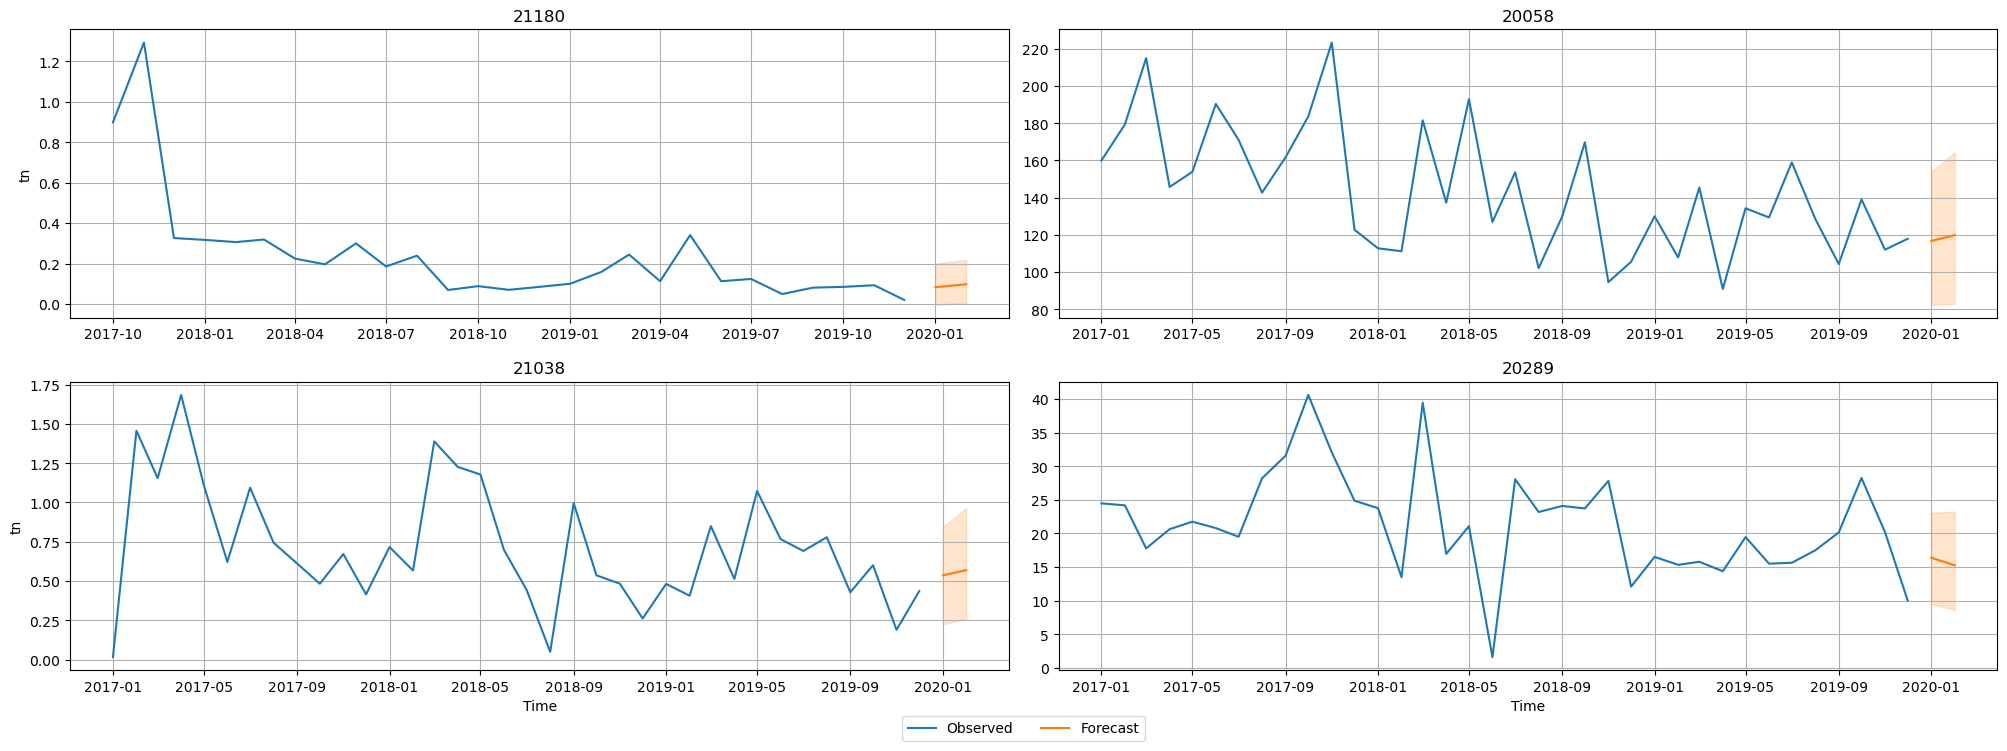

In [51]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [52]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [53]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [54]:
resultado

,product_id,tn
1,20001,1298.693005
3,20002,1048.612711
5,20003,677.048681
7,20004,501.986238
9,20005,494.769513
...,...,...
1551,20962,2.989700
1553,20975,2.618118
1555,20995,2.332743
1557,21087,0.917146


In [56]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv19.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1298.693005
3,20002,1048.612711
5,20003,677.048681
7,20004,501.986238
9,20005,494.769513


In [60]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['0.6'].reset_index()
print(forecast_mean.columns)

# Tomar solo item_id y la predicción 'mean'
resultado = forecast['0.6'].reset_index()[['item_id', '0.6']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['0.6'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', '0.6']]
resultado.columns = ['product_id', 'tn']

# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_lhv21.csv", index=False)
resultado.head()

Index(['item_id', 'timestamp', '0.6'], dtype='object')


,product_id,tn
1,20001,1381.472916
3,20002,1143.063926
5,20003,723.201341
7,20004,541.188283
9,20005,534.740893


In [ ]:
# from autogluon.common import space

# # ⚙️ 5. Definir y entrenar predictor
# predictor = TimeSeriesPredictor(
#     prediction_length=2,
#     target='tn',
#     eval_metric="MASE",
#     freq='MS'  # Frecuencia mensual (Month Start), 
# )

# predictor.fit(
#     ts_data,
#     presets="best_quality",    
#     hyperparameters={
#         "DeepAR": {
#             "hidden_size": space.Int(20, 100),
#             "dropout_rate": space.Categorical(0.1, 0.3),
#         },
#         "Theta": [
#             {"decomposition_type": "additive"},
#             {"seasonal_period": 1},
#         ],
#         "Chronos": [
#             {
#                 "model_path": "bolt_small", 
#                 "ag_args": {"name_suffix": "ZeroShot"}
#             },
#             {
#                 "model_path": "bolt_small", 
#                 "fine_tune": True, 
#                 "ag_args": {"name_suffix": "FineTuned"}
#             },
#             {
#                 "model_path": "bolt_small",
#                 "covariate_regressor": "CAT",
#                 "target_scaler": "standard",
#                 "ag_args": {"name_suffix": "WithRegressor"},
#             },            
#         ]        
#     },
#     enable_ensemble=True,
#     time_limit=3600
# )

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250703_023005'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.57 GB / 31.71 GB (27.0%)
Disk Space Avail:   176.32 GB / 952.62 GB (18.5%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'MS',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_m